In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import PIL
import os
from scipy.special import gamma
import scipy.optimize as optimization

# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import statstuff as sts

# # Development
# import importlib
# importlib.reload(sts)

In [2]:
%matplotlib notebook

In [3]:
# Graphics parameters
fontsize = 10
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [4]:
# Set defaults for the analysis
accumlist = [] # This will be all segments unless overridden 

# Only turn this on if we want PDF in terms of Z^2
IwantZ2intervals = True
Iwantlogrintervals = True

if (IwantZ2intervals):
    numforZ2hist = 25
    Z2minforhist = 1e-4; #print(Z2minforhist)
    rmaxforZ2hist = 0.1; Z2maxforhist = 1/(1-rmaxforZ2hist)**2-1; print(Z2maxforhist)
    Z2maxforhist = 0.23; #print(Z2maxforhist)
    
if (Iwantlogrintervals):
    numforhist = 70
    rminforhist = 1e-7
    rmaxforhist = .6

0.23456790123456783


In [5]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentroot='Segments'

/Users/katiegray/ice4/crystals/2018-07-17/Case1.5
2018-07-17/Case1.5


In [6]:
# Derivative names
Compressedfilename = Segmentroot+'retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentroot+'roughness.jpg'; print(Roughnessfile)
RoughnessZ2file = Segmentroot+'roughnessZ2.jpg'; print(RoughnessZ2file)
RoughnessZ2datafile = Segmentroot+'roughnessZ2.txt'; print(RoughnessZ2datafile)
Roughnessdatafile=Segmentroot+'roughness.txt'; print(Roughnessdatafile)
Roughnessfitfile=Segmentroot+'roughnessfit.txt'; print(Roughnessfitfile)

Segmentsretrieved.npz
Segmentsroughness.jpg
SegmentsroughnessZ2.jpg
SegmentsroughnessZ2.txt
Segmentsroughness.txt
Segmentsroughnessfit.txt


In [7]:
# Get the retrieved surface
npzfile = np.load(Compressedfilename)
imageroot = np.array_str(npzfile['imageroot'])
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("dx and dy", dx, dy)

dx and dy 0.6614583 0.6614583


In [8]:
# Setting up windows for where the data are, and the accumulation array
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
solution = npzfile['solution']
nsegments = len(nx1list)
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)] 
print('Completed',case) #Prints loading but I wanted to know when it was done.

Completed 2018-07-17/Case1.5


<IPython.core.display.Javascript object>


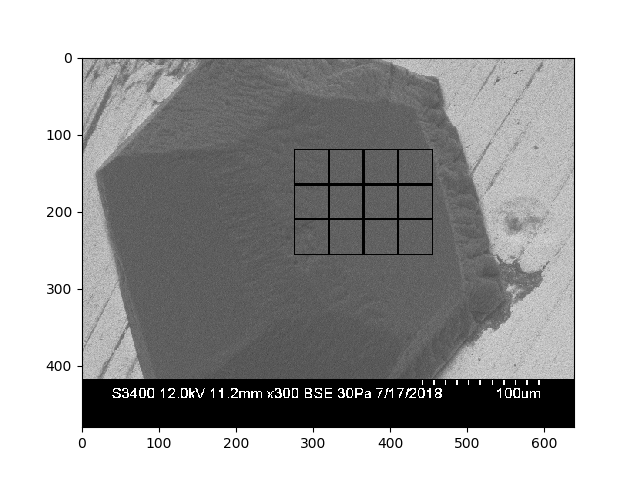

In [9]:
# Graph the segments
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)
    
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)

In [10]:
# Get the histogram as a function of log(r)
if (Iwantlogrintervals):
    newrbins=np.geomspace(rminforhist,rmaxforhist,num=numforhist)
    hbins_total, rbinsW = sts.makehistogram(\
                                 nsegments,nx1list,nx2list,ny1list,ny2list,dx,dy,solution,\
                                 accumlist, newrbins)

../../../imagestuff.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(G, z)


Accumulating ... 1 out of 12
Accumulating ... 2 out of 12
Accumulating ... 3 out of 12
Accumulating ... 4 out of 12
Accumulating ... 5 out of 12
Accumulating ... 6 out of 12
Accumulating ... 7 out of 12
Accumulating ... 8 out of 12
Accumulating ... 9 out of 12
Accumulating ... 10 out of 12
Accumulating ... 11 out of 12
Accumulating ... 12 out of 12
Norm = 203.87982522276727


<IPython.core.display.Javascript object>


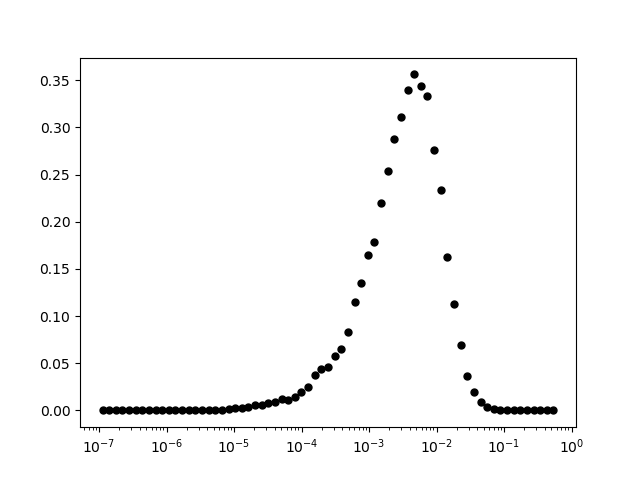

In [11]:
# Just checking the histogram looks good
plt.figure()
plt.semilogx(rbinsW,hbins_total,'ok',markersize=5)

Gaussian: best_sigma =  0.10150014217580726
Weibull: best_sigma =  0.10094372628262444
Weibull: best_eta =  0.9453229203026038
Bimodal: best_sigma1,N1 =  0.09342958163226345 0.7704104487282886
Bimodal: best_sigma2,N2 =  0.1386258936226006 0.2295895512717115
R^2 (Gauss) =  0.9953507190454195
R^2 (Weibull) =  0.998403693558839
R^2 (Bimodal) =  0.9991345241921472


<IPython.core.display.Javascript object>


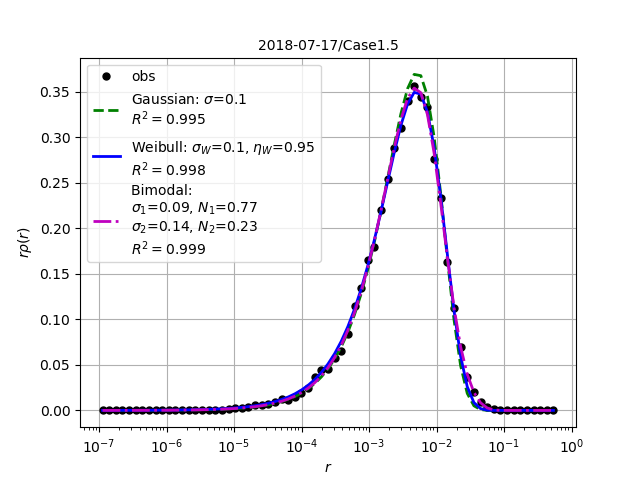

In [12]:
# Analysis of this histogram
if (Iwantlogrintervals): 
    # Get the best Weibull fit
    x0 = np.array([0.1])
    fsolution, fsolutionerror = optimization.curve_fit(sts.pGaussianr, rbinsW, hbins_total, x0)
    best_sigmaG = fsolution[0]; 
    print('Gaussian: best_sigma = ', best_sigmaG)

    # Get the best Weibull fit
    x0 = np.array([0.1,1.0])
    fsolution, fsolutionerror = optimization.curve_fit(sts.pWeibullr, rbinsW, hbins_total, x0)
    best_sigmaW = fsolution[0]; 
    print('Weibull: best_sigma = ', best_sigmaW)
    best_eta = fsolution[1]
    print('Weibull: best_eta = ', best_eta)

    # Get the best match for a two-gaussian fit
    x0 = np.array([0.09,0.24,.5])
    fsolution, fsolutionerror = optimization.curve_fit(sts.bimodalfunc, rbinsW, hbins_total, x0)
    best_sigma1 = fsolution[0]
    best_N1 = 1-fsolution[2]
    print('Bimodal: best_sigma1,N1 = ', best_sigma1,best_N1)
    best_sigma2 = fsolution[1]
    best_N2 = fsolution[2]
    print('Bimodal: best_sigma2,N2 = ', best_sigma2,best_N2)
    
        # Get the best-fit distributions
    hbins_gauss = sts.pWeibullr(rbinsW, best_sigmaG, 1)
    R2_G = sts.R_squar(hbins_total,hbins_gauss)
    print('R^2 (Gauss) = ', R2_G)
    hbins_bestfit = sts.pWeibullr(rbinsW, best_sigmaW, best_eta)
    R2_W = sts.R_squar(hbins_total,hbins_bestfit)
    print('R^2 (Weibull) = ', R2_W)
    hbins_bimodal = sts.bimodalfunc(rbinsW, best_sigma1, best_sigma2, best_N2)
    R2_B = sts.R_squar(hbins_total,hbins_bimodal)
    print('R^2 (Bimodal) = ', R2_B)
    
    # Labels for graph
    label_obs = 'obs'
    label_Gauss = 'Gaussian: ' \
                    +'$\sigma$='+str(np.round(best_sigmaG*100)/100) + '\n'\
                    +'$R^2=$'+str(np.round(R2_G*1000)/1000) 
    label_Weibull = 'Weibull: ' \
                    +'$\sigma_W$='+str(np.round(best_sigmaW*100)/100) \
                    +', ' +'$\eta_W$='+str(np.round(best_eta*100)/100) + '\n'\
                    +'$R^2=$'+str(np.round(R2_W*1000)/1000) 

    label_bimodal = 'Bimodal: ' + '\n'\
                    +'$\sigma_1$='+str(np.round(best_sigma1*100)/100) \
                    +', '+'$N_1$='+str(np.round(best_N1*100)/100) + '\n'\
                    +'$\sigma_2$='+str(np.round(best_sigma2*100)/100) \
                    +', '+'$N_2$='+str(np.round(best_N2*100)/100) + '\n'\
                    +'$R^2=$'+str(np.round(R2_B*1000)/1000) 

    # Graph
    plt.figure()
    plt.semilogx(rbinsW,hbins_total,'ok',markersize=5, label=label_obs)
    plt.semilogx(rbinsW,hbins_gauss,'--g',linewidth=2, label=label_Gauss)
    plt.semilogx(rbinsW,hbins_bestfit,'-b',linewidth=2, label=label_Weibull)
    plt.semilogx(rbinsW,hbins_bimodal,'-.m',linewidth=2, label=label_bimodal)
    plt.grid(True)
    plt.xlabel(r'$r$',fontsize=fontsize)
    plt.ylabel(r'$r\rho(r)$',fontsize=fontsize)
    plt.legend(loc='upper left')
    plt.title(case,fontsize=fontsize)
    
    plt.savefig(Roughnessfile)
    dummy= [rbinsW,hbins_total]
    np.savetxt(Roughnessdatafile,dummy)
    cfile = open(Roughnessfitfile,'w')
    cfile.write('&Roughness_Best_Fit\n')
    cfile.write(case+'\n\n'+'Gaussian fit:'+'\n')
    cfile.write('   '+'sigma =' +str(best_sigmaG)+'\n')
    cfile.write('   '+'R^2 ='+str(R2_G)+'\n\n'+'Weibull fit:'+'\n')
    cfile.write('   '+'sigma =' +str(best_sigmaW)+'\n')
    cfile.write('   '+'eta =' +str(best_eta)+'\n')
    cfile.write('   '+'R^2 ='+str(R2_W)+'\n\n'+'Bimodal fit:'+'\n')
    cfile.write('   '+'sigma1 =' +str(best_sigma1)+'\n')
    cfile.write('   '+'N1 =' +str(best_N1)+'\n')
    cfile.write('   '+'sigma2 =' +str(best_sigma2)+'\n')
    cfile.write('   '+'N2 =' +str(best_N2)+'\n')
    cfile.write('   '+'R^2 ='+str(R2_B)+'\n')
    cfile.close()

In [13]:
# Get the histogram as a function of Z2
if (IwantZ2intervals):

    # This calculates a normalized observed PDF as a function of Z^2 (rho(Z^2))
    newZ2bins = np.linspace(Z2minforhist,Z2maxforhist,numforZ2hist)
    newrbins = 1-(1/(newZ2bins+1))**.5

    hbins_total, rbinsW = sts.makehistogram(\
                                 nsegments,nx1list,nx2list,ny1list,ny2list,dx,dy,solution,\
                                 accumlist, newrbins)

../../../imagestuff.py:204: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, _, _, _ = np.linalg.lstsq(G, z)


Accumulating ... 1 out of 12
Accumulating ... 2 out of 12
Accumulating ... 3 out of 12
Accumulating ... 4 out of 12
Accumulating ... 5 out of 12
Accumulating ... 6 out of 12
Accumulating ... 7 out of 12
Accumulating ... 8 out of 12
Accumulating ... 9 out of 12
Accumulating ... 10 out of 12
Accumulating ... 11 out of 12
Accumulating ... 12 out of 12
Norm = 168.2499463270028


<IPython.core.display.Javascript object>


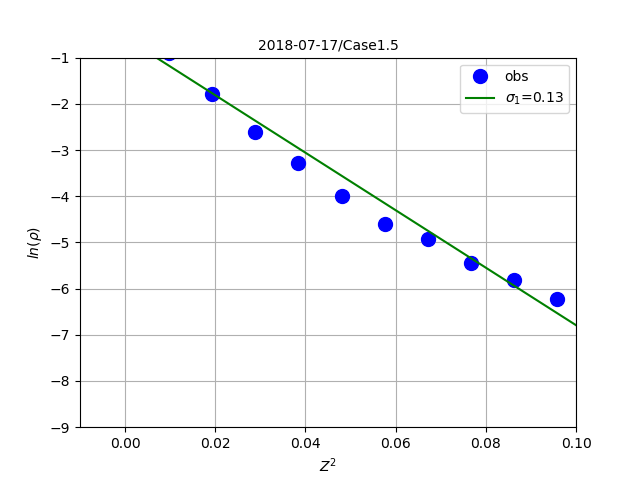

[-62.2155278   -0.57000438] predicted sigma1 =  0.12677995845604687
t1= 7.183934478155371
t2= 7.838721474093502


In [14]:
# Analysis of this histogram
if (IwantZ2intervals):

    # Do some fixing
    ikeep = np.nonzero(hbins_total)
    Z2keep = newZ2bins[ikeep]; #print(Z2keep)
    logrhoZ2 = np.log(hbins_total[ikeep]); #print(logrhoZ2)
    
    # Graph the Z^2 PDF
    plt.figure()
    plt.plot(Z2keep,logrhoZ2,'ob',markersize=10, label='obs')

    # Do some polyfitting
    thisrange = [i for i in range(0,12)]
    p1 = np.polyfit(Z2keep[thisrange],logrhoZ2[thisrange],1)
    best_sigma1 = 1/np.sqrt(-p1[0])
    print(p1,'predicted sigma1 = ', best_sigma1)
    label_sigma1 = '$\sigma_1$='+str(np.round(best_sigma1*100)/100) 
    plt.plot(Z2keep,np.polyval(p1,Z2keep),'g', label=label_sigma1)
    
#     n = len(Z2keep)
#     thisrange = [i for i in range(8,13)]
#     p2 = np.polyfit(Z2keep[thisrange],logrhoZ2[thisrange],1)
#     best_sigma2 = 1/np.sqrt(-p2[0])
#     print(p2,'predicted sigma2 = ', best_sigma2)
#     label_sigma2 = '$\sigma_2$='+str(np.round(best_sigma2*100)/100) 
#     plt.plot(Z2keep,np.polyval(p2,Z2keep),'m', label=label_sigma2)
        
    # Annotate
    plt.grid(True)
    plt.xlim([-.01,.1])
    plt.ylim([-9,-1])
    plt.xlabel('$Z^2$')
    plt.ylabel(r'$ln(\rho)$')
    plt.title(case,fontsize=fontsize)
    plt.legend()

    # Save
    np.savetxt(RoughnessZ2datafile,np.transpose([Z2keep,logrhoZ2]))
    plt.savefig(RoughnessZ2file)

    # Reporting
    meanr1 = sts.sigma2meanr(best_sigma1); theta1 = np.arccos(1-meanr1)*180/np.pi; print('t1=',theta1)
    meanr2 = sts.sigma2meanr(best_sigma2); theta2 = np.arccos(1-meanr2)*180/np.pi; print('t2=',theta2)
#     for i in range(len(newrbins)):
#         print(i,newZ2bins[i],newrbins[i])
    

In [ ]:
# rho = N * exp(-Z^2/sigma^2)